In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os
import scipy.stats as stats

In [2]:
plt.style.use('tableau-colorblind10')

In [3]:
projdir = os.getcwd()
outdir = projdir + "/output/MonteCarlo"
plotdir = projdir + "/figures"

In [4]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/tempthresholds/figures


In [5]:
scenarios = [(1,26),(2,45),(4,60),(5,85)]
surge_option = 0
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

In [6]:
def subtract_ref_npv(dfO,dfG):
    nens = dfO.ens.max()
    npv_ref = np.zeros(nens)
    df1 = dfO.loc[dfO.time==1]
    for i in range(1,nens+1):
        # first 10 of the first timestep for a single ensemble member are OptimalCost
        # *10 to account for 10-year timestep vs annual costs
        npv_ref[i-1] = np.sum(np.array(df1.loc[df1.ens==i,"cost"])[:10])*10
    dfG.npv = dfG.npv - npv_ref
    return dfG

In [126]:
dfS = {scen : None for scen in scenarios} # global NPV, GMSL, temps, brick ensemble #s, 
#dfO = {scen : None for scen in scenarios} # global optimal cost, strategies for each segment

for (ssp,rcp) in scenarios:
    slrdir = outdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR/CIAM MC2500/PostProcessing"
    dfS[(ssp,rcp)] = pd.read_csv(slrdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfO = pd.read_csv(slrdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfS[(ssp,rcp)] = subtract_ref_npv(dfO,dfS[(ssp,rcp)])

    dfR = pd.read_csv(slrdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfO = pd.read_csv(slrdir+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_global_varySLR.csv")
    dfR = dfR - dfO

    dfS[(ssp,rcp)] = dfS[(ssp,rcp)].join(dfR)
    dfS[(ssp,rcp)]["scenario"] = [str(ssp)+"-"+str(rcp)]*len(dfS[(ssp,rcp)])
    

In [127]:
dfN = pd.concat([dfS[(ssp,rcp)] for (ssp,rcp) in scenarios])

<br>

---

<br>

### NPV (global) of total adaptation costs and damages, as bar graphs with error bars

Global NPV of future adaptation costs at different thresholds

In [128]:
quants = [.05,.5,.95]
threshold_labels = ["<1.5 $^\circ$C", "1.5-2.5 $^\circ$C", "2.5-3.5 $^\circ$C", "3.5-4.5 $^\circ$C", ">4.5 $^\circ$C"]
threshold_colors = ["steelblue", "seagreen", "darkorange", "firebrick", "black"]

Heights for bar graph

In [129]:
npv_heights = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"].quantile(0.5),
                        dfN.loc[(dfN.temp2100 > 4.5), "npv"].quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [130]:
npv_uppers  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"].quantile(quants[-1]),
                        dfN.loc[(dfN.temp2100 > 4.5), "npv"].quantile(quants[-1])])
npv_lowers  = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"].quantile(quants[0]),
                        dfN.loc[(dfN.temp2100 > 4.5), "npv"].quantile(quants[0])])

In [131]:
for t in range(len(threshold_labels)):
    print(threshold_labels[t], np.round(npv_heights[t]), " (",np.round(npv_lowers[t]),"-",np.round(npv_uppers[t]),")")

<1.5 $^\circ$C 1194.0  ( 1024.0 - 1405.0 )
1.5-2.5 $^\circ$C 1527.0  ( 1192.0 - 2481.0 )
2.5-3.5 $^\circ$C 1945.0  ( 1523.0 - 2883.0 )
3.5-4.5 $^\circ$C 3683.0  ( 2682.0 - 4372.0 )
>4.5 $^\circ$C 4042.0  ( 3408.0 - 4756.0 )


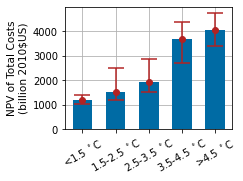

In [162]:
fig,ax = plt.subplots(1,1,figsize=(3,2.25))
plt.bar(x=threshold_labels, height=npv_heights, width=0.6)
plt.errorbar(x=threshold_labels, y=npv_heights, 
             yerr=[npv_heights-npv_lowers, npv_uppers-npv_heights],
             fmt='o', color="firebrick", elinewidth=1.5, capsize=8, capthick=1.5)
plt.ylabel("NPV of Total Costs\n(billion 2010$US)", fontsize=10.5)
plt.xticks(rotation=30, fontsize=10); plt.yticks(fontsize=10)
plt.grid(); ax.set_axisbelow(True)
fig.savefig("./figures/npv_global_bar.pdf", bbox_inches='tight');

### NPV (global), as histograms/kdes

In [133]:
npv_kde = [stats.gaussian_kde(dfN.loc[(dfN.temp2100 <= 1.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv"]),
           stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 4.5), "npv"])]

KDEs of GMSL

(gmsl saved as relative to 1995-2014)

In [134]:
gmsl_kde = [stats.gaussian_kde(dfN.loc[(dfN.temp2100 <= 1.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "gmsl2100"]),
            stats.gaussian_kde(dfN.loc[(dfN.temp2100 > 4.5), "gmsl2100"])]

combined version (NPV + GMSL)

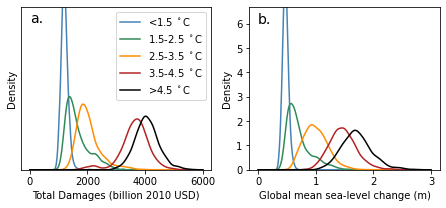

In [135]:
fig,ax = plt.subplots(1,2,figsize=(7.5,3))

# NPV
x = np.linspace(start=0, stop=6000, num=500)
for t in range(len(threshold_labels)):
    ax[0].plot(x, npv_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
ax[0].set_xlabel("Total Damages (billion 2010 USD)"); ax[0].set_ylabel("Density"); ax[0].set_yticks([])
ax[0].legend(); ax[0].text(0,0.0028,"a.",fontsize=14); ax[0].set_ylim([0,0.0031])

# GMSL
x = np.linspace(start=0, stop=3, num=500)
for t in range(len(threshold_labels)):
    ax[1].plot(x, gmsl_kde[t].evaluate(x), color=threshold_colors[t], label=threshold_labels[t])
ax[1].set_xlabel("Global mean sea-level change (m)"); ax[1].set_ylabel("Density"); #ax[1].set_yticks([])
ax[1].text(0,6,"b.",fontsize=14); ax[1].set_ylim([0,6.7])
fig.savefig("./figures/npv+gmsl2100_kde.pdf", bbox_inches='tight');

### NPV, regional breakdown as %gdp as in the example below

Adapted from code in `raddleverse/CIAM_uncertainty_propagation` (Copyright, Wong, Rennels et al). citations:
* Wong, T. (2022). CIAM uncertainty propagation experiment codes and output files (v1.0.1). Zenodo. https://doi.org/10.5281/zenodo.6835363
*  Wong, T. E., Ledna, C., Rennels, L., Sheets, H., Errickson, F. C., Diaz, D., & Anthoff, D. (2022). Sea level and socioeconomic uncertainty drives high-end coastal adaptation costs. Earth's Future, 10, e2022EF003061. https://doi.org/10.1029/2022EF003061 

https://github.com/raddleverse/CIAM_uncertainty_propagation/blob/master/work_uncertainty_propagation/plotsAndAnalysis_uncertaintyPropagation.ipynb

In [136]:
scenarios = [(1,26),(2,45),(4,60),(5,85)]

gdp per capita (just first year (2010), all in US$2010)

In [137]:
ypcc = {scen : pd.read_csv(projdir+"/data/ssp/ypcc_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
dfGP = {scen : pd.DataFrame() for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["rgn"] = ypcc[scen].columns[1:]
    dfGP[scen]["gdp_per_capita"] = np.array(ypcc[scen].iloc[0][1:])

population (millions)

In [138]:
pop = {scen : pd.read_csv(projdir+"/data/ssp/pop_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["pop"] = np.array(pop[scen].iloc[0][1:])

get total gdp

In [139]:
for scen in scenarios:
    dfGP[scen]["gdp"] = dfGP[scen]["gdp_per_capita"]*dfGP[scen]["pop"]*1e6/1e9 
# 1e6 since population is in units of millions
# and /1e9 to get in units of billions US$2010

mapping of segments/regions in CIAM, to the 7 World Bank regions

gdp is in units of billions US$2010, since the NPV results are also billions

In [140]:
wbsegs = pd.read_csv(projdir+"/data/segments_regions_WB.csv")
regions = list(wbsegs["global region"].unique())
rgn_gdp = {scen : {} for scen in scenarios}
for scen in scenarios:
    for rgn in regions:
        rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
        rgn_gdp[scen][rgn] = dfGP[scen].loc[dfGP[scen]["rgn"].isin(rgns_this_rgn),"gdp"].sum()

compute npv as %gdp (in 2010)

In [141]:
for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    for rgn in regions:
        dfN.loc[dfN.scenario==scen_str, "npv/gpd "+rgn] = 100*dfN.loc[dfN.scenario==scen_str, rgn] / \
                                                        rgn_gdp[scen][rgn]

global NPV as %GDP

In [142]:
for scen in scenarios:
    scen_str = str(scen[0])+"-"+str(scen[1])
    dfN.loc[dfN.scenario==scen_str, "npv/gpd"] = 100*dfN.loc[dfN.scenario==scen_str, "npv"] / \
                                                    np.sum(list(rgn_gdp[scen].values()))

In [143]:
print(dfN.columns)

Index(['npv', 'gmsl2100', 'temp2100', 'retreat', 'brickEnsInd',
       'Europe and Central Asia', 'Middle East and North Africa',
       'Sub-Saharan Africa', 'Latin America and the Caribbean',
       'East Asia and Pacific', 'South Asia', 'North America', 'scenario',
       'npv/gpd Europe and Central Asia',
       'npv/gpd Middle East and North Africa', 'npv/gpd Sub-Saharan Africa',
       'npv/gpd Latin America and the Caribbean',
       'npv/gpd East Asia and Pacific', 'npv/gpd South Asia',
       'npv/gpd North America', 'npv/gpd'],
      dtype='object')


Heights for bar graphs

In [144]:
npv_heights_rgn = {rgn : None for rgn in regions+["global"]}

for rgn in regions:
    npv_heights_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd "+rgn].quantile(0.5),
                                     dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd "+rgn].quantile(0.5)])
npv_heights_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd"].quantile(0.5),
                                      dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd"].quantile(0.5)])

Upper and lower bounds of error bar (will need to get length for `plt.errorbar`)

In [145]:
npv_uppers_rgn = {rgn : None for rgn in regions+["global"]}
npv_lowers_rgn = {rgn : None for rgn in regions+["global"]}

for rgn in regions:
    npv_uppers_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd "+rgn].quantile(quants[-1]),
                                    dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd "+rgn].quantile(quants[-1])])
    npv_lowers_rgn[rgn] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd "+rgn].quantile(quants[0]),
                                    dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd "+rgn].quantile(quants[0])])
npv_uppers_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd"].quantile(quants[-1]),
                                     dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd"].quantile(quants[-1])])
npv_lowers_rgn["global"] = np.array([dfN.loc[(dfN.temp2100 <= 1.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 1.5) & (dfN.temp2100 <= 2.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 2.5) & (dfN.temp2100 <= 3.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 3.5) & (dfN.temp2100 <= 4.5), "npv/gpd"].quantile(quants[0]),
                                     dfN.loc[(dfN.temp2100 > 4.5), "npv/gpd"].quantile(quants[0])])

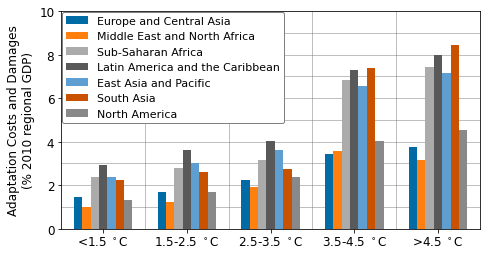

In [147]:
x = np.array([1,3,5,7,9])

dx = -0.6
fig,ax = plt.subplots(1,1,figsize=(7.5,4))
for w in [2,4,6,8]:
    plt.plot([w,w],[0,10],color="gray",linewidth=0.5)
for y in range(1,10):
    plt.plot([0,10],[y,y],color="gray",linewidth=0.5, zorder=0)
for r in range(len(regions)):
    plt.bar(x+dx, npv_heights_rgn[regions[r]], width=0.2, label=regions[r], zorder=3)
    dx += 0.2
plt.xlim([0,10]); plt.xticks(x, labels=threshold_labels, fontsize=12)
plt.ylim([0,10]); plt.yticks(fontsize=12)
plt.ylabel("Adaptation Costs and Damages\n(% 2010 regional GDP)", fontsize=12)
plt.legend(edgecolor="gray", framealpha=1, fontsize=11, borderaxespad=0.03)#plt.legend(frameon=False)
#plt.grid(); ax.set_axisbelow(True)
fig.savefig("./figures/npv_regional_bar.pdf", bbox_inches='tight');

Increases from one temperature threshold bin to the next

In [148]:
for rgn in regions:
    diffs = np.diff(npv_heights_rgn[rgn])
    print(f'{rgn:33}: {diffs[0]:0.3} {diffs[1]:0.3} {diffs[2]:0.3} {diffs[3]:0.3}')

Europe and Central Asia          : 0.249 0.523 1.2 0.312
Middle East and North Africa     : 0.23 0.701 1.64 -0.426
Sub-Saharan Africa               : 0.393 0.375 3.66 0.608
Latin America and the Caribbean  : 0.702 0.413 3.23 0.73
East Asia and Pacific            : 0.667 0.6 2.96 0.59
South Asia                       : 0.384 0.141 4.62 1.08
North America                    : 0.358 0.679 1.65 0.524


<Axes: >

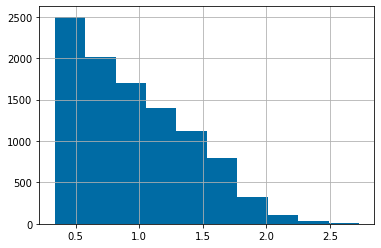

In [149]:
dfN["gmsl2100"].hist()

<Axes: >

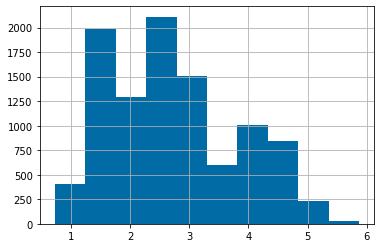

In [150]:
dfN["temp2100"].hist()

In [158]:
print(1.5,len(dfN.loc[dfN.temp2100 <= 1.5]))
for th in [2,3,4]:
    print(th,len(dfN.loc[abs(dfN.temp2100-th)<=0.5]))
print(4.5,len(dfN.loc[dfN.temp2100 > 4.5]))

1.5 1574
2 3070
3 2889
4 1691
4.5 776


# TODO- draw equal-sized subsets (500? 750?) from each threshold to make sure quantiles are not sensitive to the sample sizes